# RnD Quintile Evaluation — HW 1

Read in the data and import packages

In [2]:
import pandas as pd
from scipy.stats import t
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fund_yearly = pd.read_csv('annual_xrd_expense.csv') #From CRSP/COMP Fundamentals Yearly
sec_monthly = pd.read_csv('monthly_security_data.csv') #From CRSP/COMP Securities Monthly

**Prepare the Fundamentals Annual Data for Merge**
-  Apply Filters
-  Change date to be date time object
-  Lag the research expenditure column by 3 months via group by shift
-  Fill NaN with 0. Should not have issues with the shift as we pulled data starting earlier than needed

In [4]:
is_usd = fund_yearly['curcd'] == 'USD' #Include only US currencyies
is_us = fund_yearly['fic'] == 'USA' #Include only US companies
is_fin = (fund_yearly['sic'] >= 6000) & (fund_yearly['sic'] <= 6999) #Include companies with financial SIC code, negate mask in filter
is_not_pharm = fund_yearly['sic'] != 2834 #Exclude companies with pharma SIC code
is_us_exchg = (fund_yearly['exchg'] >= 11) & (fund_yearly['exchg']<= 19) #Include US exhcange code
is_not_free = fund_yearly['prcc_f'] != 0 #Entries with 0 price will cause problems later
has_shares = fund_yearly['csho'] != 0 #Entries with 0 shares outstanding will cause problems later

fundY = fund_yearly[is_usd & is_us & ~is_fin & is_not_pharm & is_us_exchg & is_not_free & has_shares]
fundY['datadate'] = pd.to_datetime(fundY['datadate'], format='%Y/%m/%d') #Change datadate to date time type in pandas
fundY['xrd'] = fundY['xrd'].fillna(0) #Consider NaN to be zero expense
fundY = fundY.sort_values(by=['LPERMNO','datadate']) #Recreate hierarchical index


C:\Users\Joe\AppData\Local\Temp\ipykernel_19460\3959633314.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundY['datadate'] = pd.to_datetime(fundY['datadate'], format='%Y/%m/%d') #Change datadate to date time type in pandas
C:\Users\Joe\AppData\Local\Temp\ipykernel_19460\3959633314.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundY['xrd'] = fundY['xrd'].fillna(0) #Consider NaN to be zero expense


**Create the sorting variable variable**

-  Use: $RDC_{t} = XRD_{t} + 0.8XRD_{t-1} + 0.6XRD_{t-2} + 0.4XRD_{t-3} + 0.2XRD_{t-4}$
-  Create the market cap variable as price $\times$ shares outstanding
-  Divide by market cap to get RDC/ME
-  Shift the data forward one year in time to reflect holdings at time of investment

In [5]:
fundY['year'] = fundY['datadate'].dt.year  # Extract the year from the 'datadate' column
def calculate_rdc(x):
    # This function calculates the RDC for each row
    weights = [1, 0.8, 0.6, 0.4, 0.2]
    rdc = sum(x['xrd'].shift(i).fillna(0) * weights[i] for i in range(len(weights))) #note that we treat unrecorded data as 0
    return rdc

# Apply the function to each group
fundY['RDC'] = fundY.groupby('LPERMNO').apply(lambda x: calculate_rdc(x)).reset_index(level=0, drop=True)
fundY['mcap'] = fundY['prcc_f']*fundY['csho'] #Create market cap var
fundY['RDC/ME'] = fundY['RDC'] / fundY['mcap']

##New -- Apply additional filters that Jordana and Vanessa explored
fundY = fundY[~(fundY['mcap'] < 10)] # Filter out super small cap firms
fundY = fundY.drop_duplicates(subset=['year', 'LPERMNO']) #Drop duplicate LPERMNO, year entries
fundY['datadate'] = fundY['datadate'] + pd.DateOffset(years=1) #institute a one year lag to avoid look ahead and to reflect portfolio holdings
fundY['year'] = fundY['year'] + 1 #institue the lag in the year column as well

**Create the Quintile column**
-  Split non RnD firms from RnD firms
-  Call non RnD Quintile 0
-  Qcut the RnD firms to create the Quintiles
-  Put data frame back together

In [6]:
nonRnD = fundY[fundY['RDC/ME'] == 0].dropna(subset= 'RDC/ME')
nonRnD['Quintile'] = 0 
RnD5 = fundY[fundY['RDC/ME'] > 0].dropna(subset= 'RDC/ME')
RnD5['Quintile'] = RnD5.groupby('year')['RDC/ME'].transform(lambda x: pd.qcut(x, q=5, duplicates='drop', labels=False)) +1 # Form quintiles and add 1 for indexing purposes
dfq = pd.concat([nonRnD, RnD5], axis = 0)[['LPERMNO', 'mcap', 'Quintile', 'RDC/ME', 'year']] #Merge back the non-RnD and RnD data with the quintile column added

**Prepare Monthly Security data for merge**
-  Apply filters
-  Format and change date column to date time
-  Sort data frame heirarchically, first by LPERMNO and then by date to prepare for forward fill
-  Divide returns by 100 to fit into decimal

In [9]:
is_not_letters = ~sec_monthly['trt1m'].astype(str).str.contains('[a-zA-Z]', na=False) #remove returns with letters
is_not_sub100 = sec_monthly['trt1m'] >=-100 #Include only returns greater than -100
is_fin_2 = (sec_monthly['sic'] >= 6000) & (sec_monthly['sic'] <= 6999) #Include companies with financial SIC code, negate mask in filter
is_not_pharm_2 = sec_monthly['sic'] != 2834 #Exclude companies with pharma SIC code
is_us_exchg_sec = (sec_monthly['exchg'] >= 11) & (sec_monthly['exchg']<= 19) #Include US exhcange code

secM = sec_monthly[is_not_letters & is_not_sub100 & is_us_exchg_sec & ~is_fin_2 & is_not_pharm_2].dropna(subset=['trt1m']) #apply filters and drop NA returns
secM['datadate'] = pd.to_datetime(secM['datadate'], format='%Y/%m/%d') #Change datadate to date time type in pandas
secM['year'] = secM['datadate'].dt.year
secM = secM[secM['trt1m'] < 1000]
secM['trt1m'] = secM['trt1m']/100
secM = secM.sort_values(by=['LPERMNO','datadate'])

**Do the merge**
-  Drop NaN values from monthly security data to avoid problems. Most NaN values should be from shares outstanding data that didn't get filled in from the forward fill. This would be because they were early NaNs that came before any shares outstanding information
-  Do the merge 
-  Convert returns from precentage to decimal
-  Create the sorting variable, RDC/ME which is the RDC weighted average over market cap

In [11]:
x = secM[['LPERMNO', 'datadate', 'year', 'trt1m', 'conm']].dropna() #prepare secM for merge
df = pd.merge(x, dfq, on=['LPERMNO', 'year'], how='left').sort_values(by=['LPERMNO','datadate']).dropna(subset = 'mcap')
df['datadate'] = pd.to_datetime(df['datadate'], format='%m/%d/%Y') #ensure new time index column is date time

**Calculate Value Weighted Returns**
- Create a total market cap variable that is the same accross LPERMNO for a given date and quintile
- Shift the value weight back in time to represent the balancing before the return (i.e. the composition of the return rebalanced the month before) 

In [12]:
df['total_market_cap'] = df.groupby(['datadate', 'Quintile'])['mcap'].transform('sum')
df['value weight t+1'] = df['mcap'] / df['total_market_cap']
# Then, calculate the value-weighted return
df['value weight'] = df.groupby(['LPERMNO'])['value weight t+1'].shift(1)
df['vwr'] = df['value weight']*df['trt1m']
df = df.dropna(subset = ['value weight', 'vwr'])

**Redo the last step with 1000 Largest firms (by mcap) removed for each data date**


In [13]:
def drop_largest_1000(group):
    return group.nsmallest(len(group) - 1000, 'mcap') 

df2 = df.groupby('datadate', group_keys=False).apply(drop_largest_1000).reset_index().drop(columns=['index']).sort_values(by=['LPERMNO','datadate'])

df2['total_market_cap'] = df2.groupby(['datadate', 'Quintile'])['mcap'].transform('sum')
df2['value weight'] = df2['mcap'] / df2['total_market_cap']
# Then, calculate the value-weighted return
df2['vwr'] = df2['value weight']* df2['trt1m']

In [23]:
#df.to_csv("finaldf.csv", index=True)

Custom function for the regression

In [17]:
import statsmodels.api as sm
import re

fama = pd.read_csv("FAMA3.csv")
def todate(string):
    return str(string)[:4] + '-' + str(string)[4:] + '-01'
fama['datadate'] = fama['datadate'].map(todate)
fama['datadate'] = pd.to_datetime(fama['datadate'], format='%Y/%m/%d')
fama.set_index('datadate', inplace=True)
fama.index = fama.index + pd.DateOffset(months=1) - pd.DateOffset(days=1)

def reg(series1, series2):
    M = sm.add_constant(series2)
    model = sm.OLS(series1, M).fit()
    return [model.params[0], model.params[1], model.tvalues[0], model.pvalues[0]] #In order: alpha, beta,t stat, p value

def fama3(seriesx, fama3f):
    X = sm.add_constant(fama3f)
    model = sm.OLS(seriesx, X).fit()
    return [model.params[0], model.tvalues[0]]

def capm(seriesx, start, end):
    y = seriesx.loc[start:end]

    ret_mean = y.mean()
    ret_geo = y.add(1).prod()**(1/(len(y))) -1  
    
    fama3f = fama[['Mkt-RF', 'SMB', 'HML']].loc[start:end]/100
    rf = fama['RF'].loc[start:end]/100
    
    sharpe = (ret_mean - rf.mean())/y.std()
    sharpe_ann = sharpe*(12**.5)
    return reg(y -rf, fama3f['Mkt-RF']) + fama3(y -rf, fama3f) + [sharpe_ann, ret_mean, ret_geo]

def capmls(seriesx, start, end):
    y = seriesx.loc[start:end]

    ret_mean = y.mean()
    ret_geo = y.add(1).prod()**(1/(len(y))) -1  
    
    fama3f = fama[['Mkt-RF', 'SMB', 'HML']].loc[start:end]/100
    rf = fama['RF'].loc[start:end]/100
    
    sharpe = (ret_mean)/y.std()
    sharpe_ann = sharpe*(12**.5)
    return reg(y, fama3f['Mkt-RF']) + fama3(y, fama3f) + [sharpe_ann, ret_mean, ret_geo]
    
def getlists(split, starts, ends):
    reg_stats = []
    for i in range(len(starts)):
            for quint in range(6):
                reg_stats.append(capm(split[:,quint], starts[i], ends[i]))
            reg_stats.append(capmls(split[:,5] - split[:,1], starts[i], ends[i]))
    return reg_stats

def maketable(df1, df2):
    RNDsplit = df1.groupby(['datadate', 'Quintile'])['trt1m'].mean()
    RNDsplitvw = df1.groupby(['datadate', 'Quintile'])['vwr'].sum()
    RNDsplitSC = df2.groupby(['datadate', 'Quintile'])['trt1m'].mean()
    
    starts = ['1981-07-01', '1981-07-01', '2000-01-01','2013-01-01' ]
    ends =  ['2012-12-31', '1999-12-31','2012-12-31', '2022-12-31' ]
    
    date_index_names = ['Overall: 1981-07 to 2012-12']*7 + ['t1: 1981-07 to 1999-12']*7 + ['t2: 2000-1 to 2012-12']*7 + ['Modern: 2013-01 to 2022-12']*7
    column_names = ['alpha', 'beta', 'tstat', 'pval', 'ff3alpha', 'ff3tstat', 'sharpe', 'retm', 'retg']
    quintile_index_names = ['No RnD', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4', 'Quintile 5', 'Long/Short']*4
    multi_index = pd.MultiIndex.from_arrays([date_index_names, quintile_index_names ], names=('Date Range', 'Quintile'))
    
    splits_list = [RNDsplit, RNDsplitvw, RNDsplitSC]
    
    port_names = ['equal', 'value', 'smallcap']
    for port in range(3):   
        df = pd.DataFrame(getlists(splits_list[port], starts, ends), columns=column_names, index=multi_index)
        df.to_csv(port_names[port] + '_stats.csv', index=True)
        #print(df)

In [18]:
maketable(df,df2)

# Extra Code


C:\Users\Joe\AppData\Local\Temp\ipykernel_121160\1264094997.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_id['datadate'] = pd.to_datetime(df_one_id['datadate'], format='%m/%d/%Y')


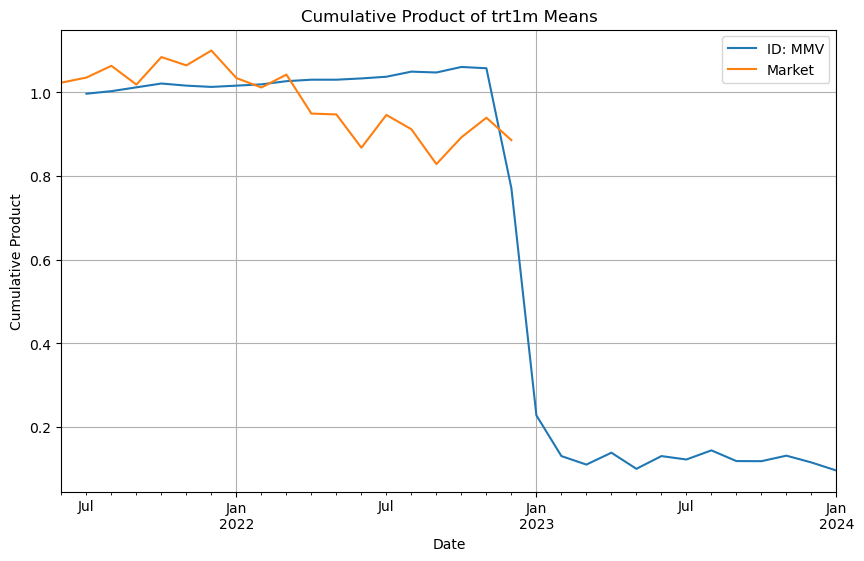

In [125]:

#93436
random_ID = sec_monthly['tic'].drop_duplicates().sample().iloc[-1]

df_one_id = sec_monthly[sec_monthly['tic'] == random_ID]
df_one_id['datadate'] = pd.to_datetime(df_one_id['datadate'], format='%m/%d/%Y')
df_one_id.set_index('datadate', inplace=True)
df_one_id = df_one_id.sort_index(ascending=True)
series = df_one_id['trt1m']/100

market['date'] = pd.to_datetime(market['date'], format='%m/%d/%Y')
market_return = market.groupby(['date'])['vwretd'].mean()

start_time = series.index.min()
end_time= series.index.max()

plt.figure(figsize=(10, 6))
series.add(1).cumprod().plot(label="ID: " + str(random_ID), legend=True)
market_return.loc[start_time:end_time].add(1).cumprod().plot(label='Market', legend=True)
plt.title('Cumulative Product of trt1m Means')
plt.xlabel('Date')
plt.ylabel('Cumulative Product')
plt.grid(True)
plt.show()

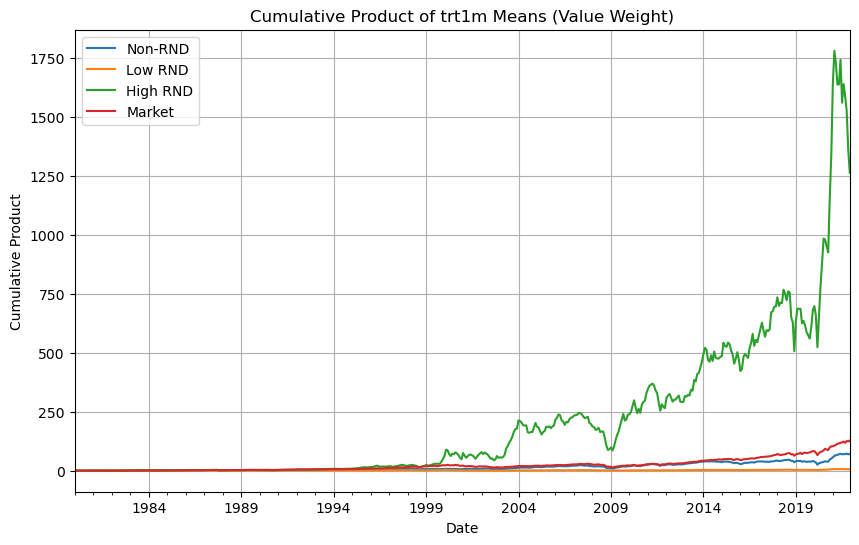

In [416]:
RNDsplit = df.groupby(['datadate', 'Quintile'])['trt1m'].mean()
RNDsplitvw = df.groupby(['datadate', 'Quintile'])['vwr'].sum()
RNDsplitSC = df2.groupby(['datadate', 'Quintile'])['trt1m'].mean()

market_return = fama['Mkt-RF']/100 + fama['RF']/100

plt.figure(figsize=(10, 6))
(RNDsplit[:,0]).loc['1980-01-01':'2022-01-01'].add(1).cumprod().plot(label="Non-RND", legend=True)
(RNDsplit[:,1]).loc['1980-01-01':'2022-01-01'].add(1).cumprod().plot(label="Low RND", legend=True)
(RNDsplit[:,5]).loc['1980-01-01':'2022-01-01'].add(1).cumprod().plot(label="High RND", legend=True)
market_return.loc['1980-01-01':'2022-01-01'].add(1).cumprod().plot(label='Market', legend=True)
plt.title('Cumulative Product of trt1m Means (Value Weight)')
plt.xlabel('Date')
plt.ylabel('Cumulative Product')
plt.grid(True)
plt.show()